## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [79]:
import sys
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnF
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [31]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [134]:
class DataProcessorFNO:
    def __init__(self, data_file_name = '../problems/poisson/data/Poisson_FNO_samples.npz', \
                 num_train = 1900, num_test = 100, \
                 num_Y_components = 1):
        
        self.data = np.load(data_file_name)
        self.tol = 1.0e-9

        self.num_train = num_train
        self.num_test = num_test
        self.num_Y_components = num_Y_components 
        
        self.load_X_data(self.data)
        self.load_Y_data(self.data)

    def load_X_data(self, data, tol = 1.0e-9):

        self.num_grid_x = data['grid_x'].shape[0]
        self.num_grid_y = data['grid_x'].shape[1]

        # grid coordinates data
        self.grid_x_train = np.tile(data['grid_x'], \
                               (self.num_train, 1, 1)\
                               ).reshape(self.num_train, \
                                         self.num_grid_x, \
                                         self.num_grid_y, 1) # exra dim
        
        self.grid_y_train = np.tile(data['grid_y'], \
                               (self.num_train, 1, 1)\
                               ).reshape(self.num_train, \
                                         self.num_grid_x, \
                                         self.num_grid_y, 1) # exra dim
        
        self.grid_x_test = np.tile(data['grid_x'], \
                               (self.num_test, 1, 1)\
                               ).reshape(self.num_test, \
                                         self.num_grid_x, \
                                         self.num_grid_y, 1) # exra dim
        
        self.grid_y_test = np.tile(data['grid_y'], \
                               (self.num_test, 1, 1)\
                               ).reshape(self.num_test, \
                                         self.num_grid_x, \
                                         self.num_grid_y, 1) # exra dim
        
        # branch input data ('m' functions)
        self.X_train = data['grid_m_samples'][:self.num_train]
        self.X_train = self.X_train.reshape(self.num_train, self.num_grid_x, self.num_grid_y, 1)

        self.X_test = data['grid_m_samples'][self.num_train:(self.num_train + self.num_test)]
        self.X_test = self.X_test.reshape(self.num_test, self.num_grid_x, self.num_grid_y, 1)

        self.X_train_mean = np.mean(self.X_train, 0)
        self.X_train_std = np.std(self.X_train, 0)

        # center and scale data
        self.X_train = (self.X_train - self.X_train_mean)/(self.X_train_std + tol)
        self.X_test = (self.X_test - self.X_train_mean)/(self.X_train_std + tol)

        # combine grid coordinates and function m values
        self.X_train = np.concatenate((self.X_train, self.grid_x_train, self.grid_y_train), axis = -1)
        self.X_test = np.concatenate((self.X_test, self.grid_x_test, self.grid_y_test), axis = -1)

        self.X_train = torch.from_numpy(self.X_train).to(torch.float32)
        self.X_test = torch.from_numpy(self.X_test).to(torch.float32)
    
    def load_Y_data(self, data, tol = 1.0e-9):

        # output data ('u' functions)
        self.Y_train = data['grid_u_samples'][:self.num_train]
        self.Y_train = self.Y_train.reshape(self.num_train, self.num_grid_x, self.num_grid_y, 1)

        self.Y_test = data['grid_u_samples'][self.num_train:(self.num_train + self.num_test),:]
        self.Y_test = self.Y_test.reshape(self.num_test, self.num_grid_x, self.num_grid_y, 1)

        self.Y_train_mean = np.mean(self.Y_train, 0)
        self.Y_train_std = np.std(self.Y_train, 0)

        # center and scale data
        self.Y_train = (self.Y_train - self.Y_train_mean)/(self.Y_train_std + tol)
        self.Y_test = (self.Y_test - self.Y_train_mean)/(self.Y_train_std + tol)

        self.Y_train = torch.from_numpy(self.Y_train).to(torch.float32)
        self.Y_test = torch.from_numpy(self.Y_test).to(torch.float32)
        
    def encoder_Y(self, x):
        return (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
    
    def decoder_Y(self, x):
        return x*(self.Y_train_std + self.tol) + self.Y_train_mean
    
    def encoder_X(self, x):
        return (x - self.X_train_mean)/(self.X_train_std + self.tol)
            
    def decoder_X(self, x):
        return x*(self.X_train_std + self.tol) + self.X_train_mean

## Define network methods

In [ ]:
class FNO2DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, \
                 modes1, modes2, \
                 apply_act = True, \
                 act = nnF.gelu):
        
        super(FNO2DLayer, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.apply_act = apply_act
        self.act = act

        # parameters in nonlocal transformation
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype = torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype = torch.cfloat))

        # parameters in linear transformation
        self.w = nn.Conv2d(self.out_channels, self.out_channels, 1)

    #Complex multiplication
    def compl_mul2d(self, a, b):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        op = torch.einsum("bixy,ioxy->boxy",a,b)
        return op

    def fourier_transform(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        #Return to physical space
        x = torch.fft.irfft2(out_ft,s=(x.size(-2),x.size(-1)))
        return x
    
    def linear_transform(self, x):
        return self.w(x)
    
    def forward(self, x):
        x = self.fourier_transform(x) + self.linear_transform(x)
        if self.apply_act:
            return self.act(x)
        else:
            return x

In [113]:
class FNO2D(nn.Module):
    
    def __init__(self, num_layers, width, \
                 fourier_modes1, fourier_modes2, \
                 proj_dim_prior_output = 128):

        super(FNO2D, self).__init__()

        self.num_layers = num_layers
        self.width = width # dimension of hidden output space 
        self.fourier_modes1 = fourier_modes1
        self.fourier_modes2 = fourier_modes2

        # define hidden layers (FNO layers)
        self.fno_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.fno_layers.append(FNO2DLayer(self.width, \
                                            self.width, \
                                            self.fourier_modes1, \
                                            self.fourier_modes2))
        
        self.fno_layers[-1].apply_act = False # no activation in the last layer

        # define input-to-hidden projector
        # input has 3 components: m(x,y), x, y
        self.input_projector = nn.Linear(3, self.width)

        # define hidden-to-output projector 
        self.output_projector = nn.Linear(self.width, 1)

        # Logger
        self.train_loss_log = []
        self.test_loss_log = []
    
    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    
    def forward(self, batch):
        x = self.convert_np_to_tensor(batch['X_train'])

        # input-to-hidden projector
        x = self.input_projector(x)
        
        # rearrange x so that it has the shape (batch, width, x, y)
        x = x.permute(0, 3, 1, 2)
        
        # pass through hidden layers
        for i in range(self.num_layers):
            x = self.fno_layers[i](x)
        
        # rearrange x so that it has the shape (batch, x, y, width)
        x = x.permute(0, 2, 3, 1)

        # hidden-to-output projector
        x = self.output_projector(x)

        return x
    
    def train(self, train_data, test_data, batch_size=32, epochs = 1000, \
              lr=0.001, log=True, \
              loss_print_freq = 100):

        self.epochs = epochs
        self.batch_size = batch_size

        # we assume that X_train has the shape (num_train, num_griid_x, num_grid_y, 3) # each row is (m(x,y), x, y)
        # and Y_train has the shape (num_train, num_grid_x, num_grid_y, 1) # each row is u(x,y)
        dataloader = DataLoader(TensorDataset(train_data['X_train'], train_data['Y_train']), batch_size=batch_size, shuffle=True)

        test_dataloader = DataLoader(TensorDataset(test_data['X_train'], test_data['Y_train']), batch_size=batch_size, shuffle=True)

        # MSE loss
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # Main training loop
        for epoch in range(epochs):
            
            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for X_train, Y_train in dataloader:

                # print(X_train.shape, X_trunk.shape, Y_train.shape)
                batch = {'X_train': X_train, 'Y_train': Y_train}
                
                # removing previous gradients
                optimizer.zero_grad()

                # forward pass through model
                Y_train_pred = self.forward(batch)

                # compute loss
                loss = criterion(Y_train_pred.view(batch_size, -1), \
                                 Y_train.view(batch_size, -1)) 

                # backward pass
                loss.backward()

                # calculate avg loss across batches
                train_losses.append(loss.item())

                # update parameters
                optimizer.step()

            with torch.no_grad():
                for X_test, Y_test in test_dataloader:
                    
                    batch = {'X_train': X_test, 'Y_train': Y_test}
                    
                    # forward pass through model
                    Y_test_pred = self.forward(batch)

                    # compute test loss
                    test_loss = criterion(Y_test_pred.view(batch_size, -1), \
                                          Y_test.view(batch_size, -1))

                    test_losses.append(test_loss.item())

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True and (epoch % loss_print_freq == 0 or epoch == epochs - 1):
                print('='*30)
                print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
    
    def predict(self, test_data):
        with torch.no_grad():
            test_data_tensor = \
                {'X_train': self.convert_np_to_tensor(test_data['X_train']), \
                 'Y_train': self.convert_np_to_tensor(test_data['Y_train']) }
        
            return self.forward(test_data_tensor)

## Load data

In [135]:
num_train = 1900
num_test = 100

num_Y_components = 1 # scalar field

# training hyperparameters
batch_size = 10
epochs = 1000
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples.npz', num_train, num_test, num_Y_components)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([1900, 100, 100, 3])
Y_train: torch.Size([1900, 100, 100, 1])
X_test: torch.Size([100, 100, 100, 3])
Y_test: torch.Size([100, 100, 100, 1])


## Create model and train the network

In [122]:
num_layers = 2
width = 16 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2)

In [123]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 2.291e-01, Test Loss (l2 squared): 3.899e-02, Time (sec): 6.830
Epoch:   100, Train Loss (l2 squared): 1.772e-02, Test Loss (l2 squared): 1.552e-02, Time (sec): 6.517
Epoch:   200, Train Loss (l2 squared): 1.430e-02, Test Loss (l2 squared): 1.666e-02, Time (sec): 6.542
Epoch:   300, Train Loss (l2 squared): 1.543e-02, Test Loss (l2 squared): 1.365e-02, Time (sec): 6.266
Epoch:   400, Train Loss (l2 squared): 1.337e-02, Test Loss (l2 squared): 1.340e-02, Time (sec): 6.291
Epoch:   500, Train Loss (l2 squared): 1.315e-02, Test Loss (l2 squared): 1.368e-02, Time (sec): 6.221
Epoch:   600, Train Loss (l2 squared): 1.296e-02, Test Loss (l2 squared): 1.289e-02, Time (sec): 6.726
Epoch:   700, Train Loss (l2 squared): 1.291e-02, Test Loss (l2 squared): 1.284e-02, Time (sec): 6.299
Epoch:   800, Train Loss (l2 squared): 1.252e-02, Test Loss (l2 squared): 1.291e-02, Time (sec): 6.578
Epoch:   900, Train Loss (l2 squared): 1.249e-02, Test Loss (l2 squared):

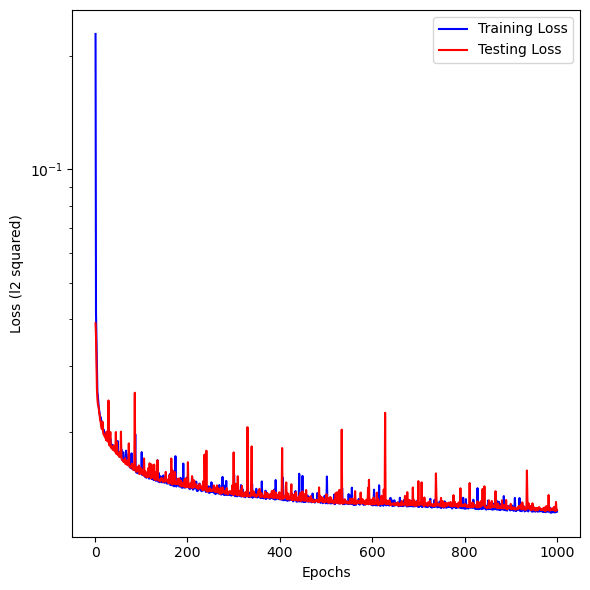

In [124]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [132]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 100, 100, 1), test_pred shape: (100, 100, 100, 1)
a shape: (100, 10000), b shape: (100, 10000)
Num tests:   100, Mean Loss (rel l2): 1.698e-01, Std Loss (rel l2): 1.206e-01


In [140]:
print('test_out shape: {}, test_pred shape: {}'.format(Y_test[0].shape, Y_test_pred[0].shape))

print(data.grid_x_train[0].shape, data.grid_y_train[0].shape)

test_out shape: (100, 100, 1), test_pred shape: (100, 100, 1)
(100, 100, 1) (100, 100, 1)


i_plot =    54, error (rel l2): 4.508e-02
i_plot =    84, error (rel l2): 1.218e-02
i_plot =    33, error (rel l2): 1.308e-02
i_plot =    53, error (rel l2): 4.560e-02
i_plot =     2, error (rel l2): 1.819e-02
i_plot =    49, error (rel l2): 1.388e-02
i_plot =    48, error (rel l2): 1.118e-02
i_plot =    82, error (rel l2): 1.301e-02
i_plot =    41, error (rel l2): 1.777e-02
i_plot =    66, error (rel l2): 1.110e-02
i_plot =    29, error (rel l2): 1.390e-02
i_plot =    37, error (rel l2): 9.619e-03
i_plot =    69, error (rel l2): 1.172e-02
i_plot =    50, error (rel l2): 1.028e-02
i_plot =    97, error (rel l2): 1.251e-02
i_plot =    59, error (rel l2): 1.590e-02


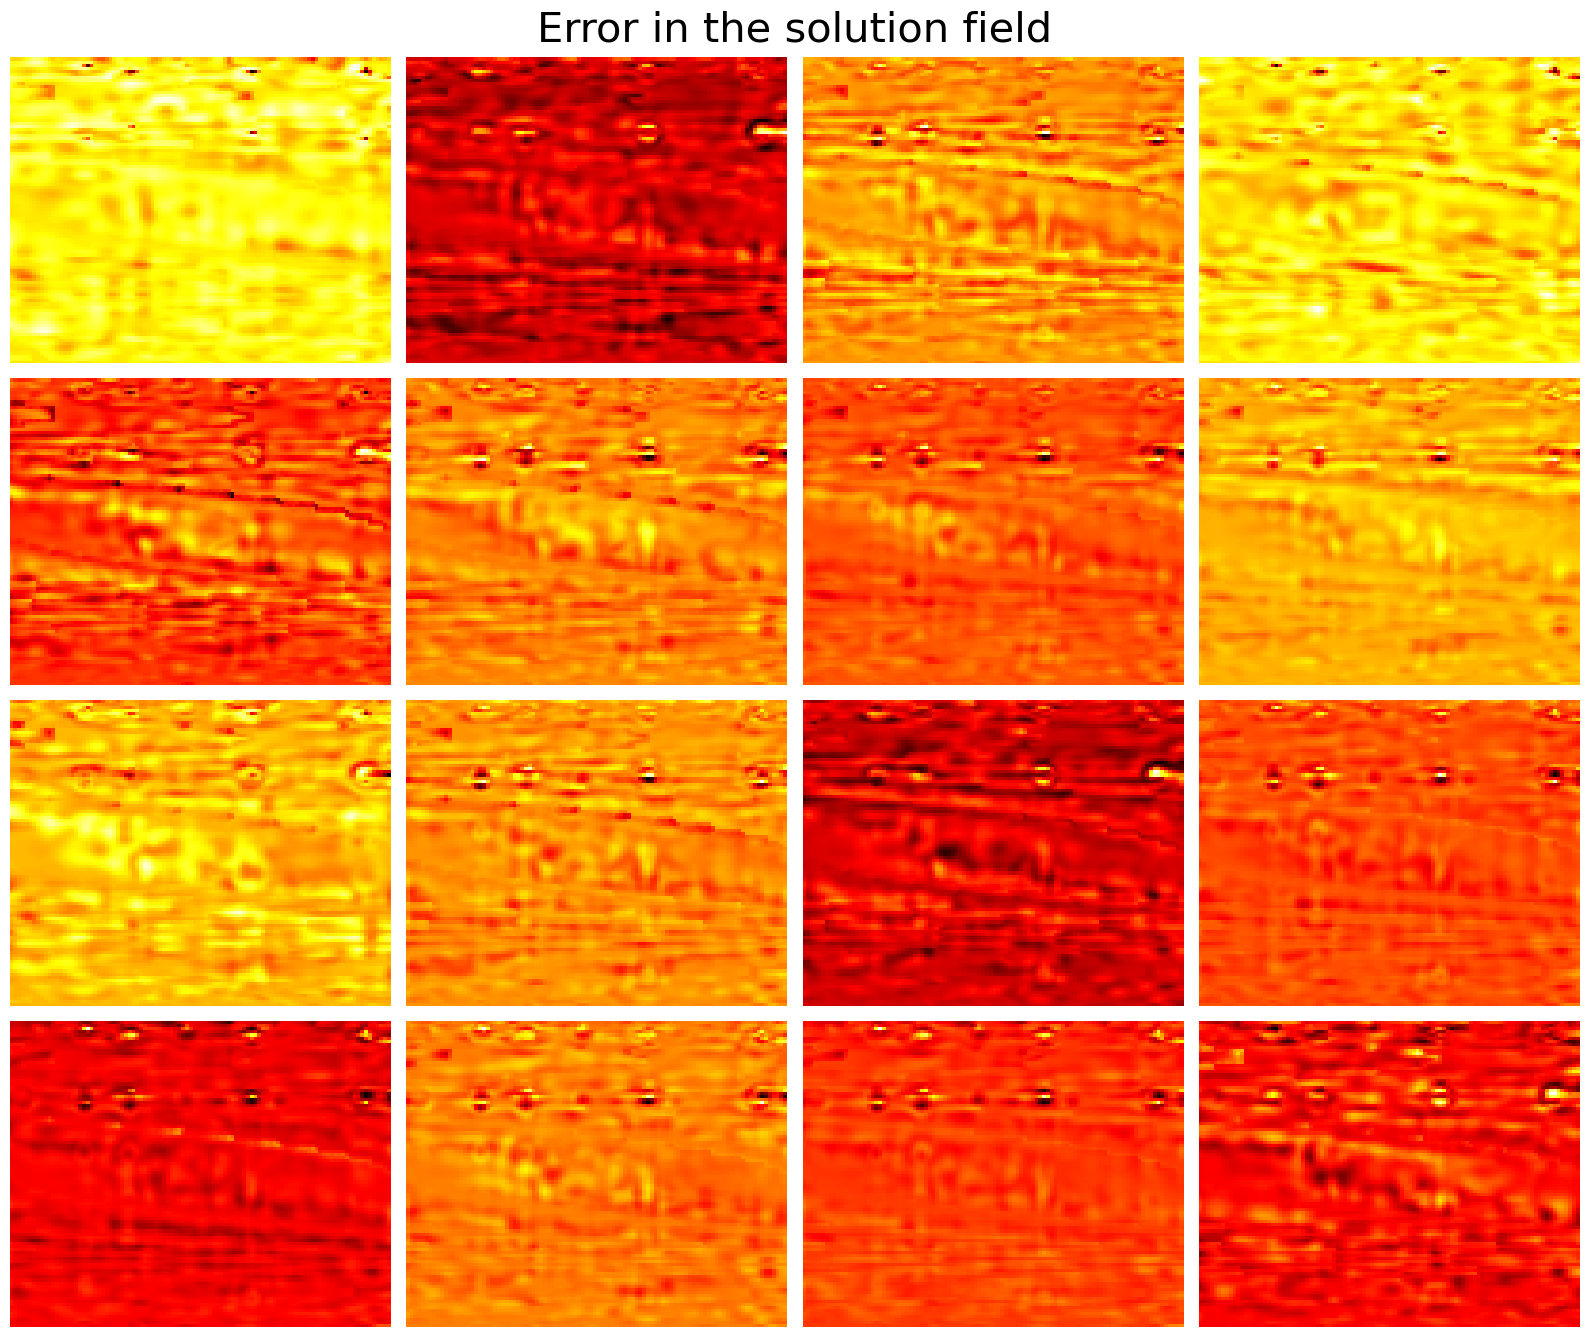

In [141]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Y_spatial_points = [data.grid_x_train[0], data.grid_y_train[0]]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot]
        i_truth = Y_test[i_plot]
        if decode:
            i_pred = data.decoder_Y(i_pred)
            i_truth = data.decoder_Y(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        axs[i,j].pcolor(nodes[0][:, :, 0], nodes[1][:, :, 0], i_diff[:,:,0], cmap='hot')

        # cbar = field_plot_fenics(axs[i,j].reshape, i_diff, Vu, cmap = 'hot')

        # divider = make_axes_locatable(axs[i,j])
        # cax = divider.append_axes('right', size='8%', pad=0.03)
        # cax.tick_params(labelsize=fs)
        # fig.colorbar(cbar, cax=cax, orientation='vertical')

        # err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        # axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    18, error (rel l2): 1.818e-03
i_plot =    29, error (rel l2): 4.755e-03
i_plot =    64, error (rel l2): 5.269e-03
i_plot =    92, error (rel l2): 8.187e-03


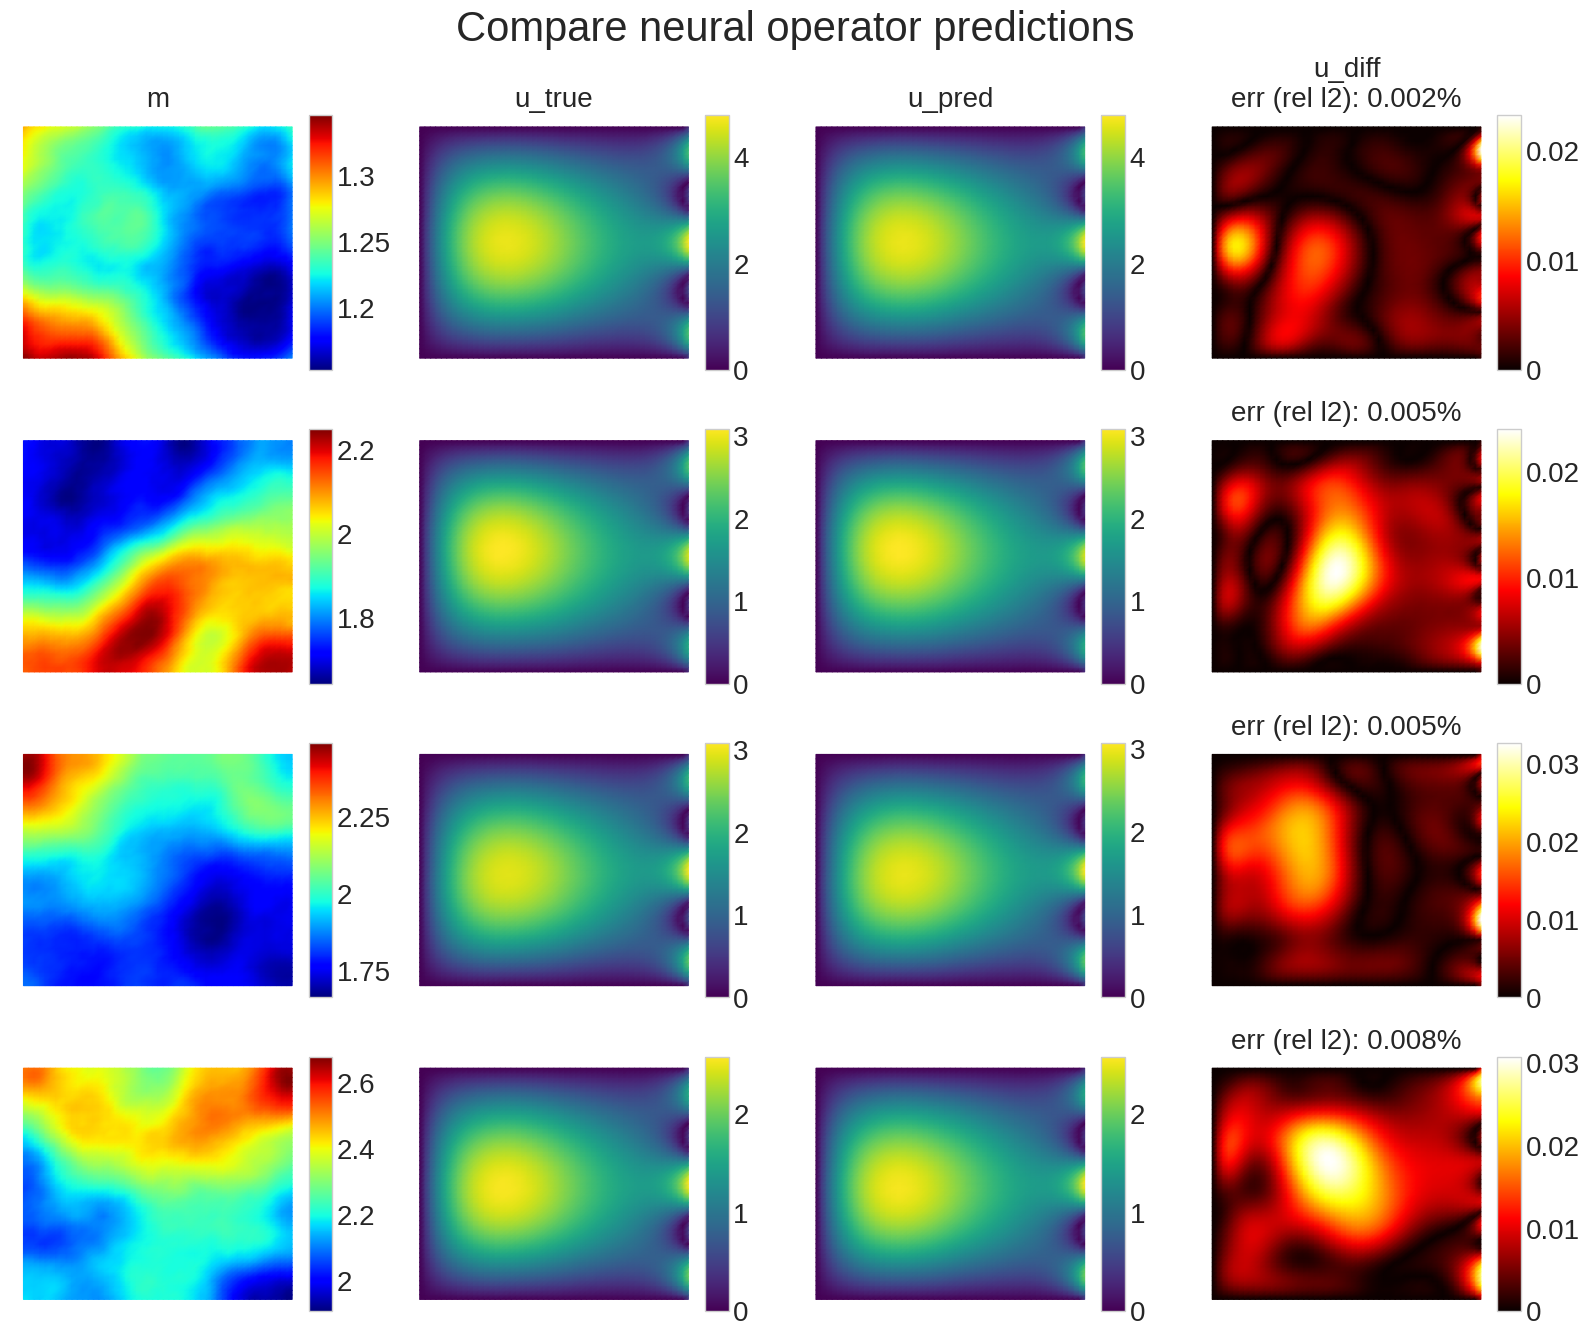

In [18]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf')
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', 'u_true', 'u_pred', 'u_diff']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()



# Scratch

### torch fno implementation blocks

In [64]:
# load data
num_train, num_test = 50, 20
data = np.load(data_folder + 'Poisson_FNO_samples.npz')
x_train = data['grid_m_samples'][:num_train]
x_test = data['grid_m_samples'][num_train:(num_train + num_test)]
y_train = data['grid_u_samples'][:num_train]
y_test = data['grid_u_samples'][num_train:(num_train + num_test)]
nx, ny = x_train.shape[1], x_train.shape[2]
print('nx: {}, ny: {}'.format(nx, ny))
print('x_train shape: {}, y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape: {}'.format(x_test.shape, y_test.shape))

grid_x_train = np.tile(data['grid_x'], (num_train, 1, 1)).reshape(num_train, nx, ny, 1)
grid_y_train = np.tile(data['grid_y'], (num_train, 1, 1)).reshape(num_train, nx, ny, 1)
print('grid_x_train shape: {}, grid_y_train shape: {}'.format(grid_x_train.shape, grid_y_train.shape))

grid_x_test = np.tile(data['grid_x'], (num_test, 1, 1)).reshape(num_test, nx, ny, 1)
grid_y_test = np.tile(data['grid_y'], (num_test, 1, 1)).reshape(num_test, nx, ny, 1)
print('grid_x_test shape: {}, grid_y_test shape: {}'.format(grid_x_test.shape, grid_y_test.shape))

x_train = x_train.reshape(num_train, nx, ny, 1)
x_test = x_test.reshape(num_test, nx, ny, 1)
print('x_train shape: {}, x_test shape: {}'.format(x_train.shape, x_test.shape))

XX_train = np.concatenate((x_train, grid_x_train, grid_y_train), axis = -1)
XX_test = np.concatenate((x_test, grid_x_test, grid_y_test), axis = -1)
XX_train = torch.from_numpy(XX_train).to(torch.float32)
XX_test = torch.from_numpy(XX_test).to(torch.float32)
YY_train = torch.from_numpy(y_train).to(torch.float32)
YY_test = torch.from_numpy(y_test).to(torch.float32)

print('XX_train shape: {}, XX_test shape: {}'.format(XX_train.shape, XX_test.shape))   


width = 32 # number of channels in hidden layer
modes = 8  # number of Fourier modes to keep 
batch_size = 4
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(XX_train, YY_train), batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(XX_test, YY_test), batch_size=batch_size, shuffle=True)

nx: 100, ny: 100
x_train shape: (50, 100, 100), y_train shape: (50, 100, 100)
x_test shape: (20, 100, 100), y_test shape: (20, 100, 100)
grid_x_train shape: (50, 100, 100, 1), grid_y_train shape: (50, 100, 100, 1)
grid_x_test shape: (20, 100, 100, 1), grid_y_test shape: (20, 100, 100, 1)
x_train shape: (50, 100, 100, 1), x_test shape: (20, 100, 100, 1)
XX_train shape: torch.Size([50, 100, 100, 3]), XX_test shape: torch.Size([20, 100, 100, 3])


In [81]:
# creat data
x, y = next(iter(train_loader))
print('x shape: {}, y shape: {}'.format(x.shape, y.shape))


s_conv = SpectralConv2d(width, width, modes, modes)
w_1d = nn.Conv1d(width, width, 1)
w_2d = nn.Conv2d(width, width, 1)

f0 = nn.Linear(3, width)
f1 = nn.Linear(width, 1)
print('w: {}, \nf1: {}, \nf2: {}'.format(w, f1, f2))

# apply projection
x = f0(x)
print('x shape: {}'.format(x.shape))
x = x.permute(0, 3, 1, 2)
print('x shape: {}'.format(x.shape))

x_w1d = w_1d(x.view(batch_size, width, -1)).view(batch_size, width, nx, ny)
x_w2d = w_2d(x)
print('x_w1d shape: {}'.format(x_w1d.shape))
print('x_w2d shape: {}'.format(x_w2d.shape))

x_scon = s_conv(x)
print('x_scon shape: {}'.format(x_scon.shape))

x = x_scon + x_w1d
print('x shape: {}'.format(x.shape))

x = nnF.gelu(x)
print('x shape: {}'.format(x.shape))

x = x.permute(0, 2, 3, 1)
print('x shape: {}'.format(x.shape))

x = f1(x)
print('x shape: {}'.format(x.shape))

y = x.reshape(batch_size, -1)
print('y shape: {}'.format(y.shape))

x shape: torch.Size([4, 100, 100, 3]), y shape: torch.Size([4, 100, 100])
w: Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1)), 
f1: Linear(in_features=32, out_features=1, bias=True), 
f2: Linear(in_features=128, out_features=1, bias=True)
x shape: torch.Size([4, 100, 100, 32])
x shape: torch.Size([4, 32, 100, 100])
x_w1d shape: torch.Size([4, 32, 100, 100])
x_w2d shape: torch.Size([4, 32, 100, 100])
x_scon shape: torch.Size([4, 32, 100, 100])
x shape: torch.Size([4, 32, 100, 100])
x shape: torch.Size([4, 32, 100, 100])
x shape: torch.Size([4, 100, 100, 32])
x shape: torch.Size([4, 100, 100, 1])
y shape: torch.Size([4, 10000])


In [75]:
n = 3
a = np.random.rand(2, 2, 10, 10)
b = a[:,:, -n:, :n]
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))  

a shape: (2, 2, 10, 10), b shape: (2, 2, 3, 3)
